# Inverse Transform Sampling
## Peter Wills, 6/8/2018

We'll use [inverse transform sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling) to sample from an arbitrary probability density. We won't require that this density is normalized; 

Make sure we can numerically integrate, so that we can build a CDF from the provided PDF (as well as normalize the PDF):

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def pdf(x):
    """A unit normal density, NOT normalized"""
    return np.exp(-x**2/2)

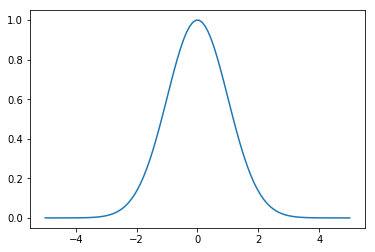

In [3]:
x = np.linspace(-5,5,100)
plt.plot(x,pdf(x));

So we've got ourselves a PDF, albeit without a normalization factor. Now let's use `sample` to draw samples from this distribution.

In [4]:
import sys; sys.path.append('/Users/peterwills/google-drive/python/my_packages/itsample/')
from itsample import sample

In [5]:
%%timeit
samples = sample(pdf,1)

3.08 ms ± 428 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
%%time
samples = sample(pdf,5000)

CPU times: user 16.7 s, sys: 196 ms, total: 16.9 s
Wall time: 18.3 s


In [7]:
from itsample import normalize
pdf_norm = normalize(pdf, vectorize=True)

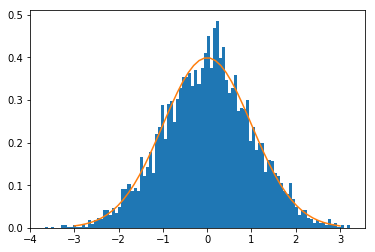

In [8]:
plt.hist(samples,bins=100,density=True);
x = np.linspace(-3,3)
plt.plot(x,pdf_norm(x))

Note that, for efficiency reasons, Let's compare this the built-in numpy sampler:

In [9]:
%%time
samples = plt.np.random.normal(size=[5000])

CPU times: user 822 µs, sys: 1.28 ms, total: 2.1 ms
Wall time: 7.18 ms


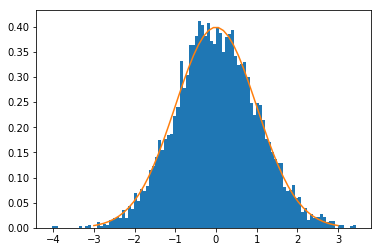

In [10]:
plt.hist(samples,bins=100,density=True);
plt.plot(x,pdf_norm(x))

Much slower, but comparable results. Suppose we wanted a normal against a a background:

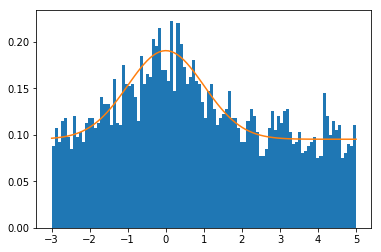

In [11]:
def pdf(x):
    """A unit normal density, NOT normalized"""
    return 1 + np.exp(-x**2/2)

lower_bd = -3
upper_bd = 5
guess = 1

samples = sample(pdf,5000,lower_bd=lower_bd,upper_bd=upper_bd, guess=guess)
pdf_norm = normalize(pdf,lower_bd=lower_bd,upper_bd=upper_bd,vectorize=True)

x = np.linspace(lower_bd,upper_bd,100)
plt.hist(samples,bins=100,density=True);
plt.plot(x,pdf_norm(x))

An exception will be raised if the PDF cannot be normalized:

In [12]:
def pdf(x):
    """A unit normal density, NOT normalized"""
    return 1 + np.exp(-x**2/2)

sample(pdf,1)

ValueError: PDF integral likely divergent.

## Chebyshev Approximation of CDF

I'm working on coding up an inverse transform sampler that uses Chebyshev approximations of the CDF to speed things up. This follows the work of [Olver & Townsend, 2013](https://arxiv.org/pdf/1307.1223.pdf).

We'll see that this approach is not as fast as we would hope. The key here is that the function `chebeval` is highly vectorized, and so is much faster than a numerically integrated CDF **when evaluated at many inputs simultaneously.** However, the root-finding functions in scipy do one evaluation at each iteration, so they do not take advantage of this vectorized structure. When doing single evaluations of the functions, `chebeval` is about the same speed as `quad`.

Let's compare the speed of the quadrature approach above to the approach of Olver & Townsend.

In [13]:
%%timeit
samples = sample(pdf,1,lower_bd=-10, upper_bd=10)

1.92 ms ± 165 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [14]:
%%timeit
samples = sample(pdf,1,lower_bd=-10, upper_bd=10,chebyshev=True)

1.85 ms ± 84.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


If we do a single sample, then speeds are approximately equal for the two methods. What if we do 5,000 samples?

In [15]:
%%time
samples = sample(pdf,5000,lower_bd=-10, upper_bd=10)

CPU times: user 7.88 s, sys: 96.6 ms, total: 7.98 s
Wall time: 8 s


In [16]:
%%time
samples = sample(pdf,5000,lower_bd=-10, upper_bd=10,chebyshev=True)

CPU times: user 3.94 s, sys: 28.4 ms, total: 3.97 s
Wall time: 3.97 s


The Chebyshev approach is faster, but not by the orders of magnitude we are hoping for.

Let's take a look at how fast calls to each CDF are:

In [17]:
from itsample import chebcdf, get_cdf

cdf = get_cdf(pdf,lower_bd,upper_bd)
cdf_cheb = chebcdf(pdf,lower_bd,upper_bd)

/Users/peterwills/google-drive/python/my_packages/itsample/itsample.py:130: RankWarning: The fit may be poorly conditioned
  coeffs = chebfit(x,y,n-1)


Calls of a single value take about the same amount of time:

In [18]:
%%timeit
cdf([0])

52.8 µs ± 832 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [19]:
%%timeit
cdf_cheb([0])

85.5 µs ± 8.2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


But vectorized calls are MUCH faster for the Chebyshev CDF.

In [20]:
x = np.linspace(lower_bd, upper_bd, 100)

In [23]:
%%timeit
cdf(x)

7.95 ms ± 707 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
%%timeit
cdf_cheb(x)

107 µs ± 13.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


However, our root-finder relies on repeated calls of the first type, so the vectorized nature of the Chebyshev CDF does not speed up our sampling.